In [1]:
import requests
from bs4 import BeautifulSoup
from collections import defaultdict
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style('whitegrid')
%matplotlib inline
pd.options.display.max_rows = 1000

# 1. Scrape HTML from Wikipedia

In [2]:
load_instead_of_scrape = True

city_to_url = [
    ('beijing', 'https://en.wikipedia.org/wiki/List_of_Beijing_Subway_stations'),
    ('Chengdu', 'https://en.wikipedia.org/wiki/List_of_Chengdu_Metro_stations'),
    ('Chongqing', 'https://en.wikipedia.org/wiki/List_of_Chongqing_Rail_Transit_stations'),
    ('Dalian', 'https://en.wikipedia.org/wiki/List_of_Dalian_Metro_stations'),
    ('Guangzhou', 'https://en.wikipedia.org/wiki/List_of_Guangzhou_Metro_stations'),
    ('Hangzhou', 'https://en.wikipedia.org/wiki/List_of_Hangzhou_Metro_stations'),
    ('Nanjing', 'https://en.wikipedia.org/wiki/List_of_Nanjing_Metro_stations'),
    ('Shanghai', 'https://en.wikipedia.org/wiki/List_of_Shanghai_Metro_stations'),
    ('Shenyang', 'https://en.wikipedia.org/wiki/List_of_Shenyang_Metro_stations'),
    ('Shenzhen', 'https://en.wikipedia.org/wiki/List_of_Shenzhen_Metro_stations'),
    ('Shijiazhuang', 'https://en.wikipedia.org/wiki/List_of_Shijiazhuang_Metro_stations'),
    ('Suzhou', 'https://en.wikipedia.org/wiki/List_of_Suzhou_Rail_Transit_stations'),
    ('Wuhan', 'https://en.wikipedia.org/wiki/List_of_Wuhan_Metro_stations'),
    ('Xian', 'https://en.wikipedia.org/wiki/List_of_Xi%27an_Metro_stations'),
]

# Define columns of interest for each metro
city_to_columns = [
    ('Beijing', False, 'Station', 'Chinese name'),
    ('Chengdu', 'Station name', 'English', 'Chinese'),
    ('Chongqing', 'Station name', 'English', 'Chinese'),
    ('Dalian', False, 'Station', 'Chinese name'),
    ('Guangzhou', False, 'Station', 'Chinese name'),
    ('Hangzhou', 'Station name', 'English', 'Chinese'),
    ('Nanjing', False, 'Station nameEnglish', 'Station nameMandarin'),
    ('Shanghai', 'Station Name', 'English', 'Chinese (S)'),
    ('Shenyang', 'station name', 'Pinyin', 'Chinese'),
    ('Shenzhen', 'Station name', 'English', 'Chinese'),
    ('Shijiazhuang', 'Station name', 'English', 'Chinese'),
    ('Suzhou', 'Station name', 'English', 'Chinese'),
    ('Wuhan', False, 'Station name(English)', 'Station name(Chinese)'),
    ('Xian', False, 'Station nameEnglish', 'Station nameMandarin'),
]

In [3]:
if not load_instead_of_scrape:
    for city_name, url in city_to_url:
        response = requests.get(url)
        with open(f'./wikipedia_html/{city_name}.txt', "w", encoding="utf-8") as file:
            file.write(response.text)
        print(city_name, len(response.text))
        time.sleep(5)
else:
    print('Proceed to just load the previously scraped data')

Proceed to just load the previously scraped data


# 2. Parse tables from each HTML to get station names

In [4]:
def remove_parentheses_and_numbers(s):
    return re.sub(r'[0-9\[\]]+', '', s)

dict_stations = defaultdict(list)
for city_name, top_level_col_name, english_col_name, chinese_col_name in city_to_columns:
    english_col_name = english_col_name.lower()
    chinese_col_name = chinese_col_name.lower()

    # Load html for the city and identify all tables
    with open(f'./wikipedia_html/{city_name}.txt', "r", encoding="utf-8") as file:
        response_text = file.read()
    soup = BeautifulSoup(response_text, 'html.parser')
    tables = soup.find_all('table')
    # print(f'{city_name} # tables: {len(tables)}')

    # Loop through each table
    for table_idx, table in enumerate(tables):
        # Get table header / column names
        headers = table.find_all('th')
        header_texts = [header.get_text(strip=True) for header in headers]
        header_texts = [h.lower() for h in header_texts]

        if top_level_col_name is False:
            # Check if table has proper columns
            if english_col_name in header_texts and chinese_col_name in header_texts:
                chinese_col_index = header_texts.index(chinese_col_name)
                english_index = header_texts.index(english_col_name)
                
                # Find all rows in the table body
                rows = table.find_all('tr')
                for i_row, row in enumerate(rows[1:]):  # Skip header row
                    cells = row.find_all(['td', 'th'])  # Sometimes headers repeat in body
                    if len(cells) > chinese_col_index:
                        chinese_text = cells[chinese_col_index].get_text(strip=True)
                        english_text = cells[english_index].get_text(strip=True)
                        dict_stations['city_name'].append(city_name)
                        dict_stations['chinese'].append(chinese_text)
                        dict_stations['english'].append(english_text)
                        dict_stations['station_number'].append(i_row)

        else:
            top_level_col_name = top_level_col_name.lower()
            # Remove all brackets and numbers from header texts
            header_texts = [remove_parentheses_and_numbers(h) for h in header_texts]
            header_texts = [h.lower() for h in header_texts]

            # Check if table has proper columns
            if top_level_col_name in header_texts and english_col_name in header_texts and chinese_col_name in header_texts:
                top_level_index = header_texts.index(top_level_col_name)
                english_index = sum([int(h.get('colspan', default=1)) for h in headers[:top_level_index]])
                chinese_col_index = english_index + 1

                # Find all rows in the table body
                rows = table.find_all('tr')
                for i_row, row in enumerate(rows[2:]):  # Skip header rows
                    cells = row.find_all(['td', 'th'])  # Sometimes headers repeat in body
                    if len(cells) > chinese_col_index:
                        chinese_text = cells[chinese_col_index].get_text(strip=True)
                        english_text = cells[english_index].get_text(strip=True)
                        dict_stations['city_name'].append(city_name)
                        dict_stations['chinese'].append(chinese_text)
                        dict_stations['english'].append(english_text)
                        dict_stations['station_number'].append(i_row)
                

df_stations = pd.DataFrame(dict_stations)

# Remove strange Wuhan artifact
df_stations = df_stations[~df_stations['chinese'].str.contains('Chinese')].reset_index(drop=True)

# Drop duplicates
print(f'# stations, pre de-dup: {len(df_stations)}')
df_stations = df_stations.drop_duplicates(subset=['city_name', 'chinese'])

print(f'# stations: {len(df_stations)}')
print(df_stations['city_name'].value_counts())
df_stations.sample(10)

# stations, pre de-dup: 3822
# stations: 3237
city_name
Beijing         416
Shanghai        408
Shenzhen        332
Chengdu         329
Guangzhou       293
Wuhan           263
Hangzhou        257
Nanjing         247
Chongqing       226
Suzhou          174
Xian            102
Shenyang         85
Shijiazhuang     62
Dalian           43
Name: count, dtype: int64


,city_name,chinese,english,station_number
732,Chengdu,张家寺,Zhangjiasi,36
1322,Guangzhou,坦尾,Tanwei,1
2350,Shanghai,鞍山新村,Anshan Xincun,8
3720,Xian,沣河森林公园,Fenghe­senlin­gongyuan†,0
62,Beijing,海淀黄庄,Haidian Huangzhuang,6
26,Beijing,传媒大学,Communication Univ. of China,26
2212,Shanghai,宜山路,Yishan Road,5
1287,Guangzhou,番禺广场,Panyu Square,25
3181,Shijiazhuang,留村,Liucun,16
429,Beijing,昌平东关,Changping Dongguan,3


# 3. Process data and get character counts

In [5]:
# Remove all parentheses and numbers using regex
def remove_parentheses_and_numbers(s):
    return re.sub(r'[0-9()·\[\]]+', '', s)

all_char = ''.join(df_stations['chinese'].values)
all_char = list(remove_parentheses_and_numbers(all_char))

# Get counts of all characters
char_counts = pd.Series(all_char).value_counts().reset_index().rename(columns={"index": 'char'})
print(char_counts.head(10))
print(len(char_counts), char_counts['count'].sum())

  char  count
0    路    649
1    大    244
2    园    186
3    桥    176
4    东    159
5    南    159
6    北    145
7    西    135
8    山    131
9    新    124
1168 10145


# 4. get pinyin

In [6]:
def load_pinyin_dict(filename):
    pinyin_dict = {}

    with open(filename, "r", encoding="utf-8") as file:
        for line in file:
            line = line.strip()

            # Skip empty lines or comments
            if not line or line.startswith("#"):
                continue

            # Split line at '#' to separate the Chinese character
            parts = line.split("#")
            if len(parts) < 2:
                continue

            chinese_char = parts[1].strip()  # e.g., 㐀

            # Split left side at ':' to get Pinyin
            left_part = parts[0].split(":")
            if len(left_part) < 2:
                continue

            pinyin = left_part[1].strip()  # e.g., qiū

            # Add to dictionary
            pinyin_dict[chinese_char] = pinyin

    return pinyin_dict

# Downloaded file from https://github.com/mozillazg/pinyin-data/blob/27dc54a206326e0d8d91428010325f50f614508d/pinyin.txt
char_to_pinyin_dict = load_pinyin_dict("pinyin.txt")
print(char_to_pinyin_dict['㐀'])  # Output: qiū

qiū


In [7]:
def get_example_stations(char, n_examples=3):
    return list(df_stations[df_stations['chinese'].str.contains(char)].head(n_examples)['chinese'].values)

char_counts['pinyin_all'] = char_counts['char'].map(char_to_pinyin_dict)
char_counts['pinyin'] = char_counts['pinyin_all'].apply(lambda x: str(x).split(',')[0])
char_counts['char_pinyin'] = char_counts.apply(lambda row: f"{row['pinyin']} {row['char']}", axis=1)
char_counts['examples'] = char_counts['char'].apply(get_example_stations)
char_counts.head(50)

,char,count,pinyin_all,pinyin,char_pinyin,examples
0,路,649,"lù,luò",lù,lù 路,"[玉泉路, 万寿路, 南礼士路]"
1,大,244,"dà,dài,tài",dà,dà 大,"[大望路, 传媒大学, 鼓楼大街]"
2,园,186,"yuán,wán",yuán,yuán 园,"[苹果园, 八角游乐园, 果园]"
3,桥,176,qiáo,qiáo,qiáo 桥,"[双桥, 八里桥, 土桥]"
4,东,159,dōng,dōng,dōng 东,"[天安门东, 东单, 四惠东]"
5,南,159,"nán,nā",nán,nán 南,"[南礼士路, 北京南站, 高米店南]"
6,北,145,"běi,bèi",běi,běi 北,"[通州北苑, 北京站, 安河桥北]"
7,西,135,xī,xī,xī 西,"[西单, 天安门西, 西直门]"
8,山,131,shān,shān,shān 山,"[八宝山, 九龙山, 昌平西山口]"
9,新,124,xīn,xīn,xīn 新,"[新街口, 新宫, 北新桥]"


# 4. plot character frequency

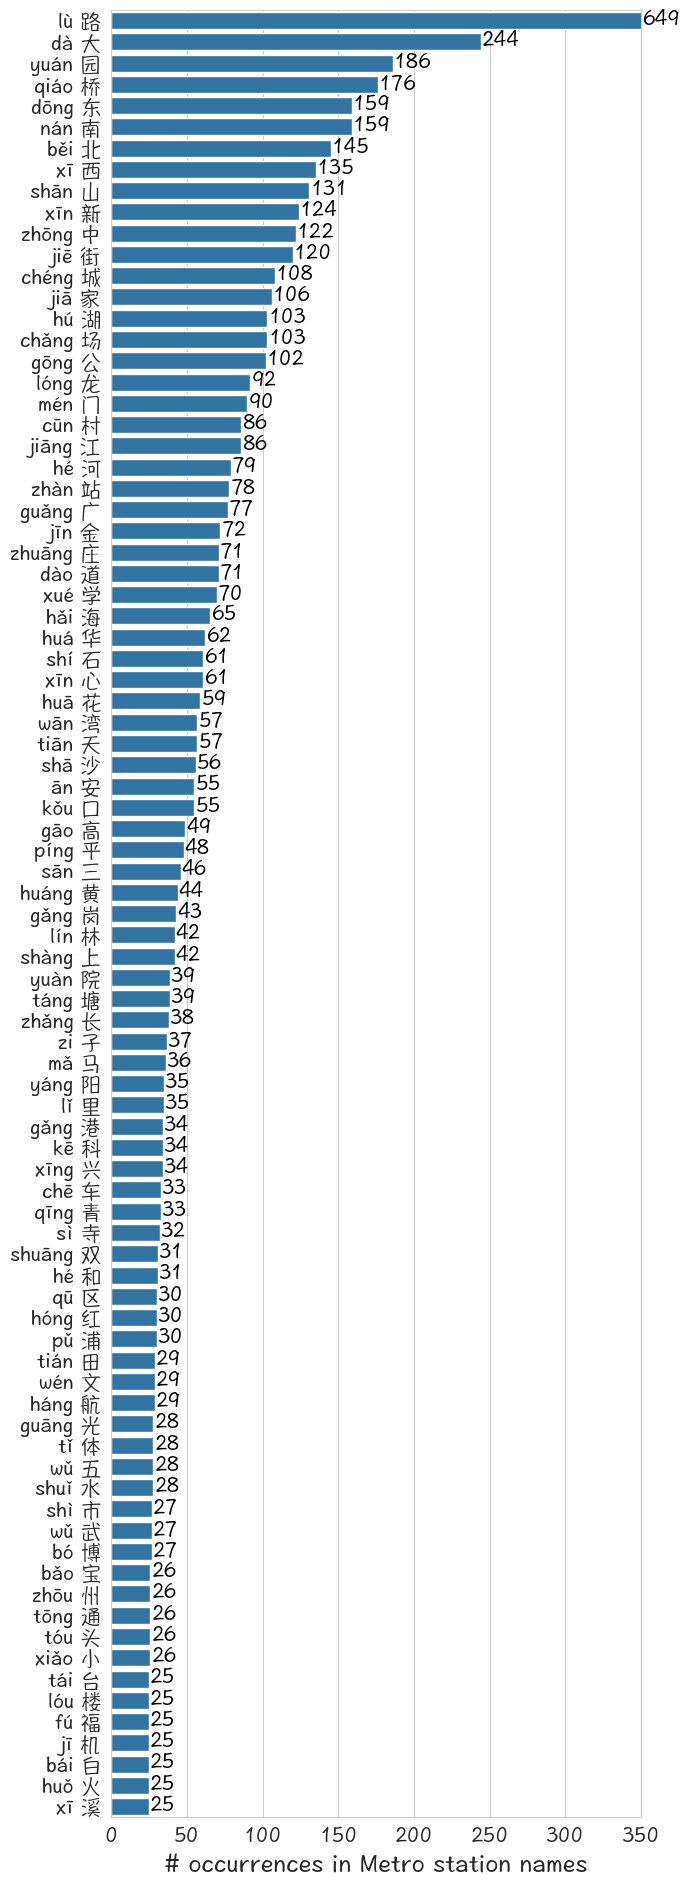

In [9]:
df_plt = char_counts[char_counts['count'] > 24].dropna().reset_index(drop=True)

# Plot bars
xaxis_limit = 350
plt.rcParams['font.family'] = 'Hannotate SC'
plt.figure(figsize=(7,19))
g = sns.barplot(x='count', y='char_pinyin', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=min(row['count'], xaxis_limit) + .7,
           y=index + .2,
           s=row['count'],
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# occurrences in Metro station names', size=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((0,xaxis_limit))
plt.tight_layout()
    
plt.savefig('./plots/metro_character_ranking_14metros.png')


# 5. top character combos

In [10]:
# Create string to use in getting character sequence counts
all_stations_str = '_'.join(df_stations['chinese'])
all_stations_str = remove_parentheses_and_numbers(all_stations_str)
print(all_stations_str[:100])

# Get all charater sequences, not including numbers or certain characters
all_seq2 = []
all_seq3 = []
all_seq4 = []
all_seq5 = []
all_seq6 = []
for let1, let2, let3, let4, let5, let6 in zip(all_stations_str[:-5], all_stations_str[1:-4], all_stations_str[2:-3], all_stations_str[3:-2], all_stations_str[4:-1], all_stations_str[5:]):
    all_seq2.append(f'{let1}{let2}')
    all_seq3.append(f'{let1}{let2}{let3}')
    all_seq4.append(f'{let1}{let2}{let3}{let4}')
    all_seq5.append(f'{let1}{let2}{let3}{let4}{let5}')
    all_seq6.append(f'{let1}{let2}{let3}{let4}{let5}{let6}')

# Remove certain characters of no interest
seq2_counts = pd.Series(all_seq2).value_counts().reset_index().rename(columns={"index": 'char'})
seq2_counts = seq2_counts[~seq2_counts['char'].str.contains('_')]
seq3_counts = pd.Series(all_seq3).value_counts().reset_index().rename(columns={"index": 'char'})
seq3_counts = seq3_counts[~seq3_counts['char'].str.contains('_')]
seq4_counts = pd.Series(all_seq4).value_counts().reset_index().rename(columns={"index": 'char'})
seq4_counts = seq4_counts[~seq4_counts['char'].str.contains('_')]
seq5_counts = pd.Series(all_seq5).value_counts().reset_index().rename(columns={"index": 'char'})
seq5_counts = seq5_counts[~seq5_counts['char'].str.contains('_')]
seq6_counts = pd.Series(all_seq6).value_counts().reset_index().rename(columns={"index": 'char'})
seq6_counts = seq6_counts[~seq6_counts['char'].str.contains('_')]

# Create dataframe of multi-character combo frequencies
# Columns: Chinese, char count, pinyin, examples
df_char_combo_counts = pd.concat([seq2_counts, seq3_counts, seq4_counts, seq5_counts, seq6_counts])
df_char_combo_counts = df_char_combo_counts[df_char_combo_counts['count'] >= 3]
df_char_combo_counts['n_char'] = df_char_combo_counts['char'].apply(lambda x: len(x))

# Get pinyin
def get_pinyin_of_char_combo(chars):
    pinyin = ''
    for char in chars:
        pinyin += char_to_pinyin_dict[char].split(',')[0]
    return pinyin

df_char_combo_counts['pinyin'] = df_char_combo_counts['char'].apply(get_pinyin_of_char_combo)
df_char_combo_counts['char_pinyin'] = df_char_combo_counts.apply(lambda row: f"{row['pinyin']} {row['char']}", axis=1)

# Get examples
df_char_combo_counts['examples'] = df_char_combo_counts['char'].apply(get_example_stations)
df_char_combo_counts.sort_values('count', ascending=False).head(20)

号_福寿岭_苹果园_古城_八角游乐园_八宝山_玉泉路_五棵松_万寿路_公主坟_军事博物馆_木樨地_南礼士路_复兴门_西单_天安门西_天安门东_王府井_东单_建国门_永安里_国贸_大望路_四惠_四惠东_


,char,count,n_char,pinyin,char_pinyin,examples
6,公园,78,2,gōngyuán,gōngyuán 公园,"[森林公园南门, 奥林匹克公园, 朝阳公园]"
15,大道,60,2,dàdào,dàdào 大道,"[华府大道, 迎宾大道, 熊猫大道]"
19,广场,57,2,guǎngchǎng,guǎngchǎng 广场,"[天府广场, 锦城广场, 双流广场]"
23,中心,52,2,zhōngxīn,zhōngxīn 中心,"[奥体中心, 亦创会展中心, 奥体中心]"
24,大学,48,2,dàxué,dàxué 大学,"[传媒大学, 北京大学东门, 人民大学]"
51,南路,26,2,nánlù,nánlù 南路,"[丰台南路, 农大南路, 红莲南路]"
56,大街,23,2,dàjiē,dàjiē 大街,"[鼓楼大街, 黄村西大街, 回龙观东大街]"
58,西路,22,2,xīlù,xīlù 西路,"[马超西路, 清江西路, 凤西路]"
60,机场,22,2,jīchǎng,jīchǎng 机场,"[大兴机场, 双流机场1航站楼, 双流机场2航站楼]"
62,北路,21,2,běilù,běilù 北路,"[人民北路, 金科北路, 草堂北路]"


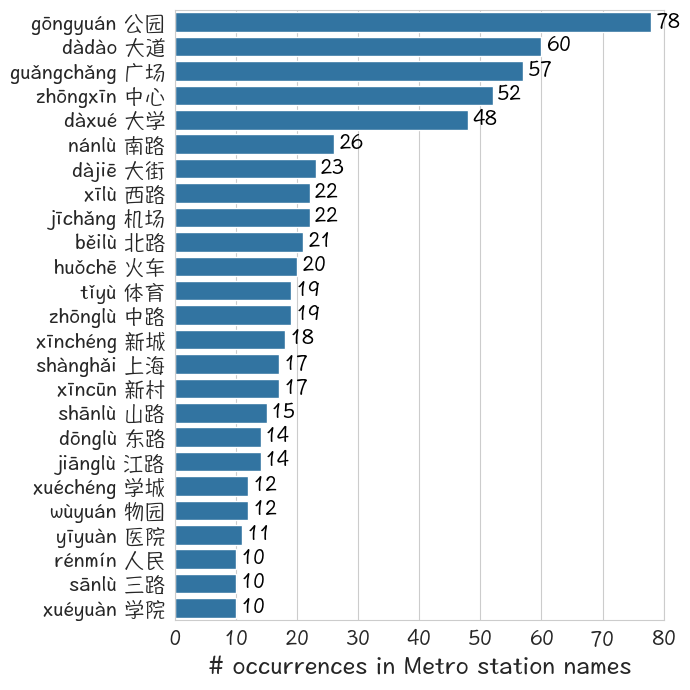

In [11]:
df_plt = df_char_combo_counts[(df_char_combo_counts['count'] > 9) & (df_char_combo_counts['n_char']==2)].dropna().reset_index(drop=True)

# Remove those with zhan
df_plt = df_plt[~df_plt['char'].str.contains('站')].reset_index(drop=True)

# Plot bars
xaxis_limit = 80
plt.rcParams['font.family'] = 'Hannotate SC'
plt.figure(figsize=(7,7))
g = sns.barplot(x='count', y='char_pinyin', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=min(row['count'], xaxis_limit) + .7,
           y=index + .2,
           s=row['count'],
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# occurrences in Metro station names', size=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((0,xaxis_limit))
plt.tight_layout()
    
plt.savefig('./plots/metro_2char_combo_ranking_14metros.png')


# 6. 3+ combo

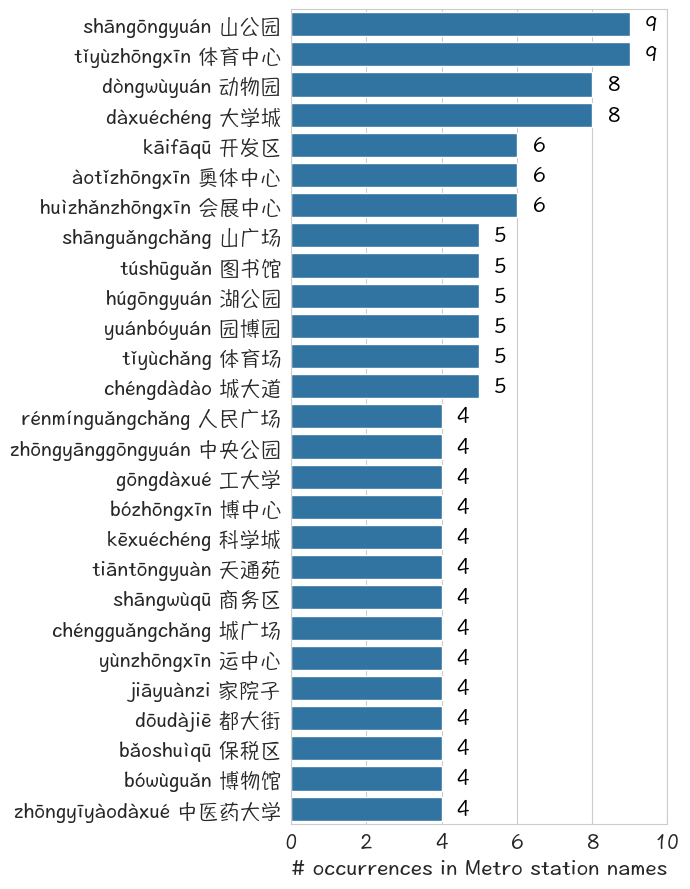

In [12]:
df_plt = df_char_combo_counts[(df_char_combo_counts['count'] > 3) & (df_char_combo_counts['n_char']>=3)].dropna().sort_values('count', ascending=False).reset_index(drop=True)

# Remove those with zhan
df_plt = df_plt[~df_plt['char'].str.contains('站')].reset_index(drop=True)

# Remove a combo if it is within another one that is present
long_combos = df_plt[df_plt['n_char'] > 3]['char'].values
def determine_if_in_long_combo(char):
    for combo in long_combos:
        if len(char) < len(combo):
            if char in combo:
                return True
    return False
df_plt['is_in_longer_combo'] = df_plt['char'].apply(determine_if_in_long_combo)
df_plt = df_plt[~df_plt['is_in_longer_combo']].reset_index(drop=True)

# Plot bars
xaxis_limit = 10
plt.rcParams['font.family'] = 'Hannotate SC'
plt.figure(figsize=(7,9))
g = sns.barplot(x='count', y='char_pinyin', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=min(row['count'], xaxis_limit) + .4,
           y=index + .2,
           s=row['count'],
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# occurrences in Metro station names', size=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((0,xaxis_limit))
plt.tight_layout()
    
plt.savefig('./plots/metro_3char_combo_ranking_14metros.png')


# 7. Save .csv of all character rankings

In [16]:
df_char_combo_counts.to_csv('tmp.csv')

In [17]:
char_counts.to_csv('tmp.csv')

# 8. city-specific plots

In [ ]:


cities = df_stations['city_name'].unique()
city = cities[0]

,char,count,pinyin_all,pinyin,char_pinyin,examples
0,桥,42,qiáo,qiáo,qiáo 桥,"[双桥, 八里桥, 土桥]"
1,庄,38,"zhuāng,péng",zhuāng,zhuāng 庄,"[管庄, 花庄, 车公庄]"
2,北,38,"běi,bèi",běi,běi 北,"[通州北苑, 北京站, 安河桥北]"
3,门,37,mén,mén,mén 门,"[复兴门, 天安门西, 天安门东]"
4,东,35,dōng,dōng,dōng 东,"[天安门东, 东单, 四惠东]"


In [170]:
# Required characters
N_CHAR_REQUIRE = 20
required_char = char_counts.head(N_CHAR_REQUIRE+1)['char'].values[1:]
df_required_char = pd.Series(required_char).reset_index().rename(columns={0:'char'})
df_required_char = df_required_char.drop('index', axis=1)
df_required_char


,char
0,大
1,园
2,桥
3,东
4,南
5,北
6,西
7,山
8,新
9,中


In [187]:
df_plt.head()

df_plt = df_plt.merge(df_required_char, on='char', how='outer')
df_plt['count'] = df_plt['count'].fillna(0)
df_plt = df_plt.sort_values('count', ascending=False)
df_plt.head(30)

,char,count,pinyin_all,pinyin,char_pinyin,examples,city_name
19,桥,42.0,qiáo,qiáo,qiáo 桥,"[双桥, 八里桥, 土桥]",Beijing
16,庄,38.0,"zhuāng,péng",zhuāng,zhuāng 庄,"[管庄, 花庄, 车公庄]",Beijing
3,北,38.0,"běi,bèi",běi,běi 北,"[通州北苑, 北京站, 安河桥北]",Beijing
29,门,37.0,mén,mén,mén 门,"[复兴门, 天安门西, 天安门东]",Beijing
26,西,35.0,xī,xī,xī 西,"[西单, 天安门西, 西直门]",Beijing
0,东,35.0,dōng,dōng,dōng 东,"[天安门东, 东单, 四惠东]",Beijing
7,园,30.0,"yuán,wán",yuán,yuán 园,"[苹果园, 八角游乐园, 果园]",Beijing
27,路,26.0,"lù,luò",lù,lù 路,"[玉泉路, 万寿路, 南礼士路]",Beijing
10,大,25.0,"dà,dài,tài",dà,dà 大,"[大望路, 传媒大学, 鼓楼大街]",Beijing
4,南,22.0,"nán,nā",nán,nán 南,"[南礼士路, 北京南站, 高米店南]",Beijing


,char,count,pinyin_all,pinyin,char_pinyin,examples,city_name
0,东,35.0,dōng,dōng,dōng 东,"[天安门东, 东单, 四惠东]",Beijing
1,中,0.0,NaN,NaN,NaN,NaN,NaN
2,公,10.0,gōng,gōng,gōng 公,"[公主坟, 车公庄, 魏公村]",Beijing
3,北,38.0,"běi,bèi",běi,běi 北,"[通州北苑, 北京站, 安河桥北]",Beijing
4,南,22.0,"nán,nā",nán,nán 南,"[南礼士路, 北京南站, 高米店南]",Beijing
5,口,14.0,kǒu,kǒu,kǒu 口,"[新街口, 菜市口, 磁器口]",Beijing
6,台,10.0,"tái,tāi,yí,sì",tái,tái 台,"[金台路, 丰台东大街, 丰台南路]",Beijing
7,园,30.0,"yuán,wán",yuán,yuán 园,"[苹果园, 八角游乐园, 果园]",Beijing
8,场,0.0,NaN,NaN,NaN,NaN,NaN
9,城,15.0,chéng,chéng,chéng 城,"[古城, 潞城, 北土城]",Beijing


,char,count,pinyin_all,pinyin,char_pinyin,examples,city_name
31,华,5.0,"huá,huà,huā",huá,huá 华,"[华阳, 九华山, 龙华路]",Nanjing
32,花,8.0,huā,huā,huā 花,"[皇花园, 花牌坊, 花照壁]",Chengdu
350,温,1.0,"wēn,yùn",wēn,wēn 温,[温阳路],Beijing
232,故,1.0,gù,gù,gù 故,[明故宫],Nanjing
223,鹿,1.0,"lù,lǘ",lù,lù 鹿,[鹿圈东],Beijing
194,尚,1.0,"shàng,cháng",shàng,shàng 尚,[金尚路],Suzhou
151,萬,1.0,wàn,wàn,wàn 萬,[浦口萬汇城],Nanjing
235,丹,1.0,dān,dān,dān 丹,[丹水池],Wuhan
120,树,2.0,shù,shù,shù 树,"[红树湾, 红树湾南]",Shenzhen
205,通,1.0,"tōng,tòng",tōng,tōng 通,[通新岭],Shenzhen


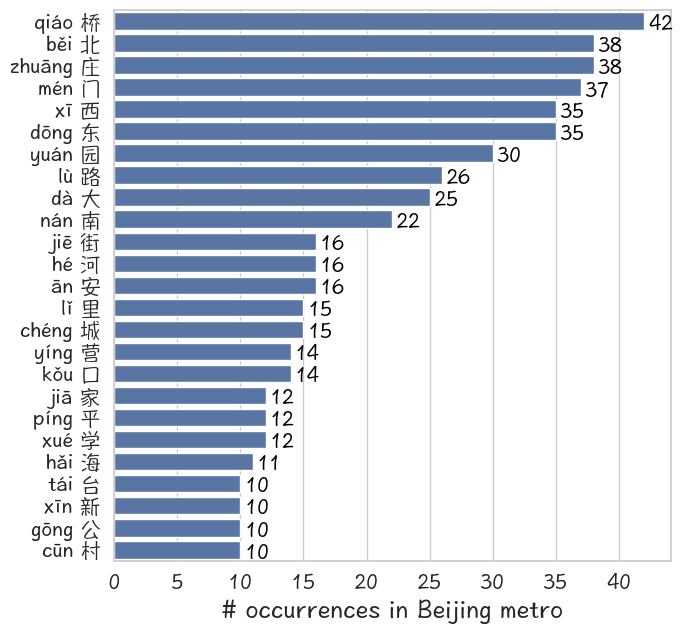

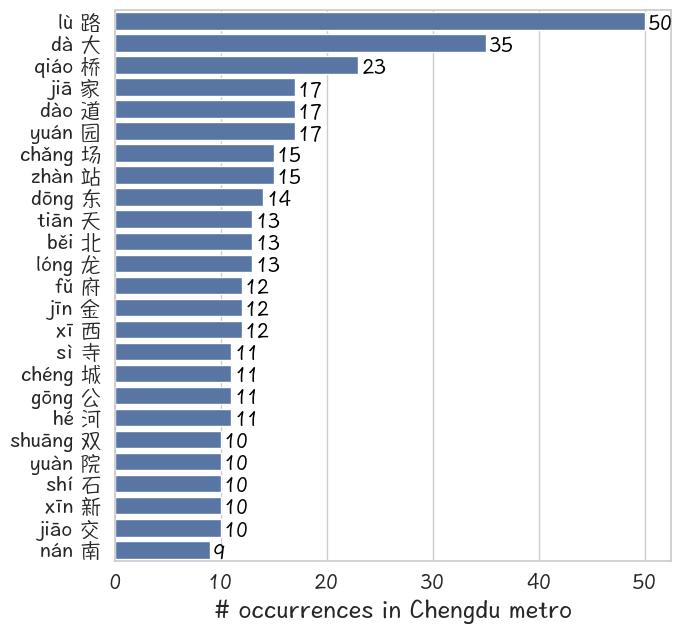

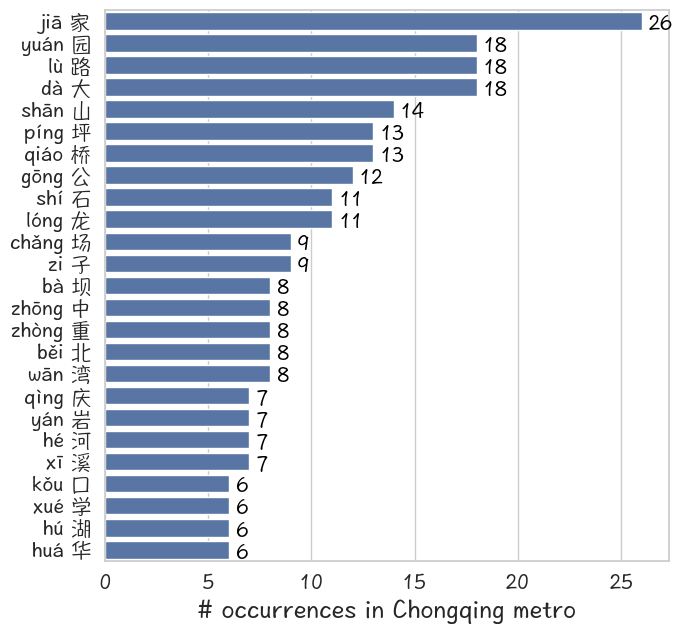

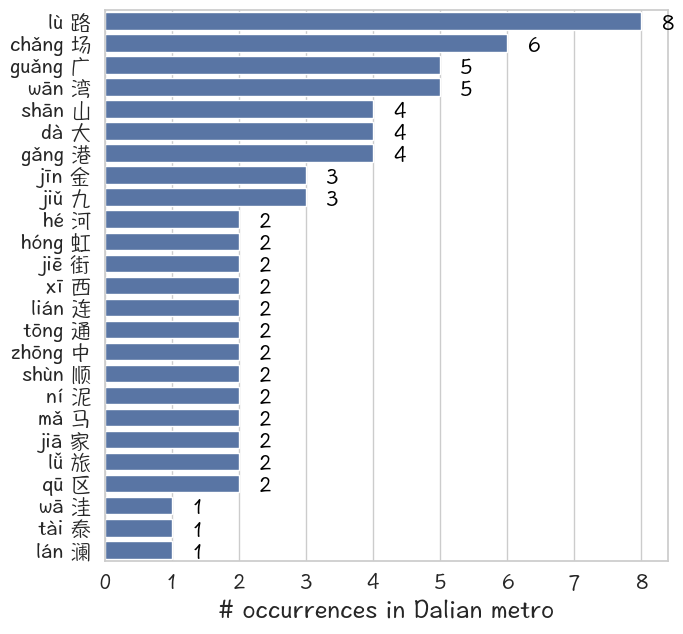

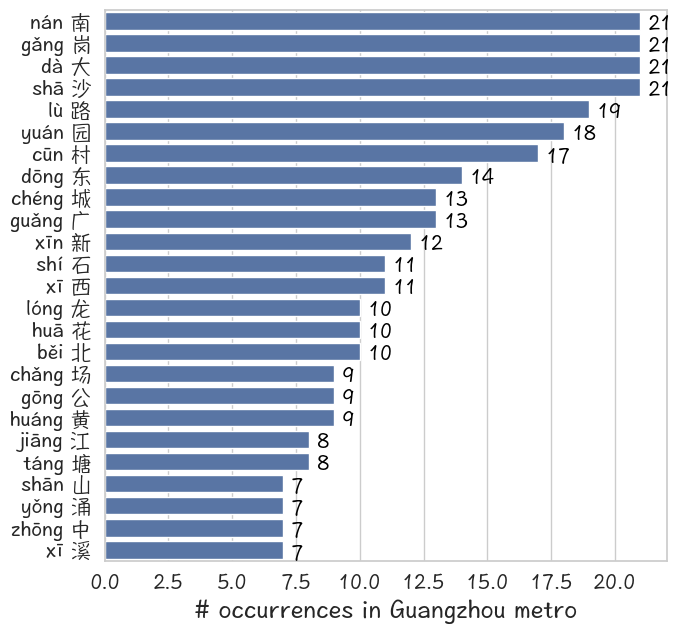

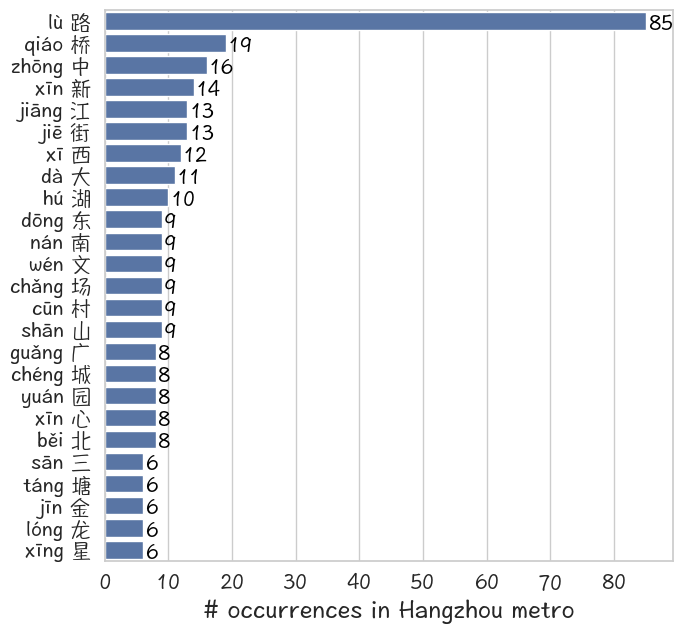

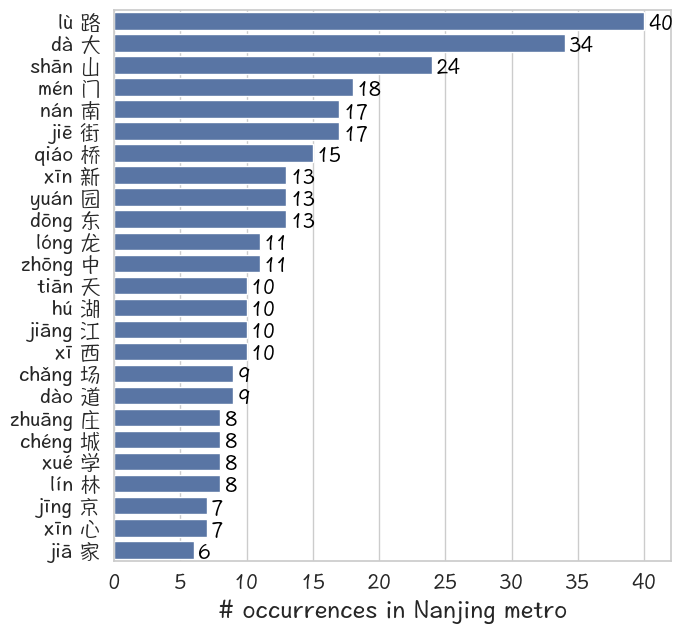

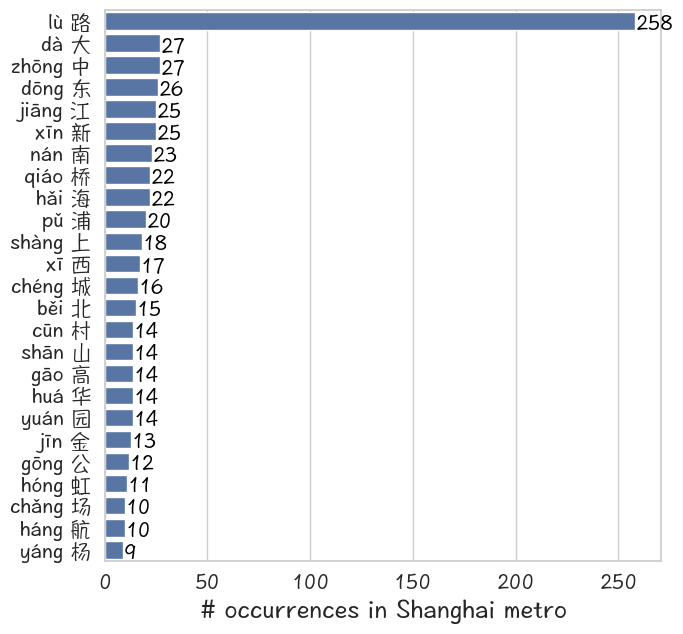

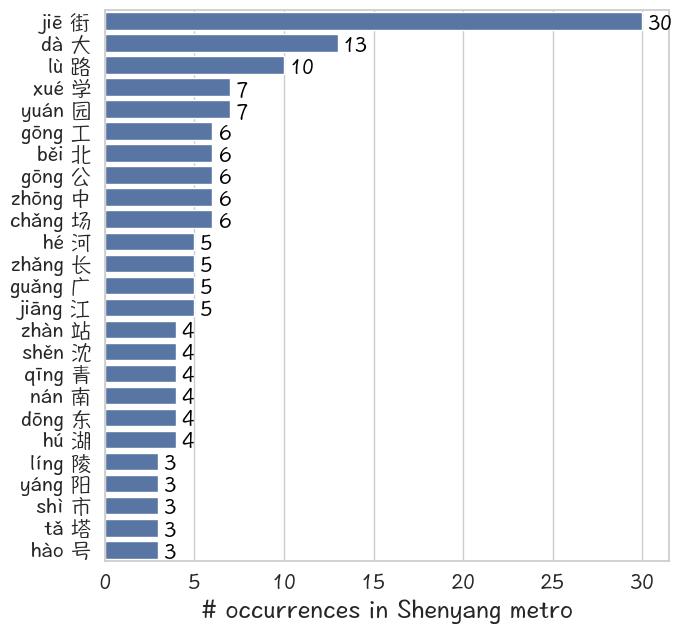

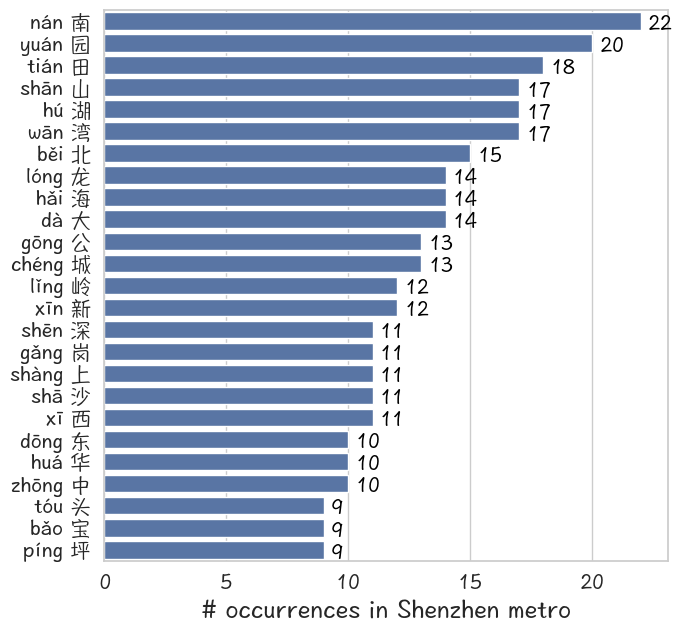

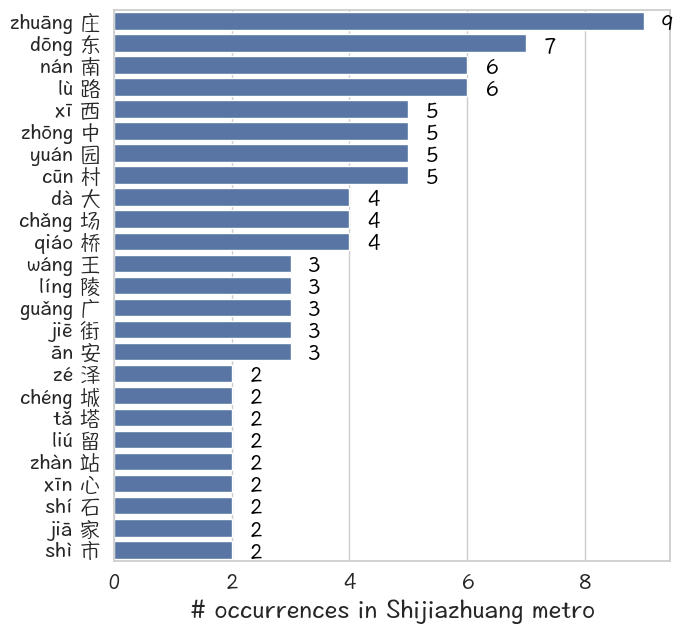

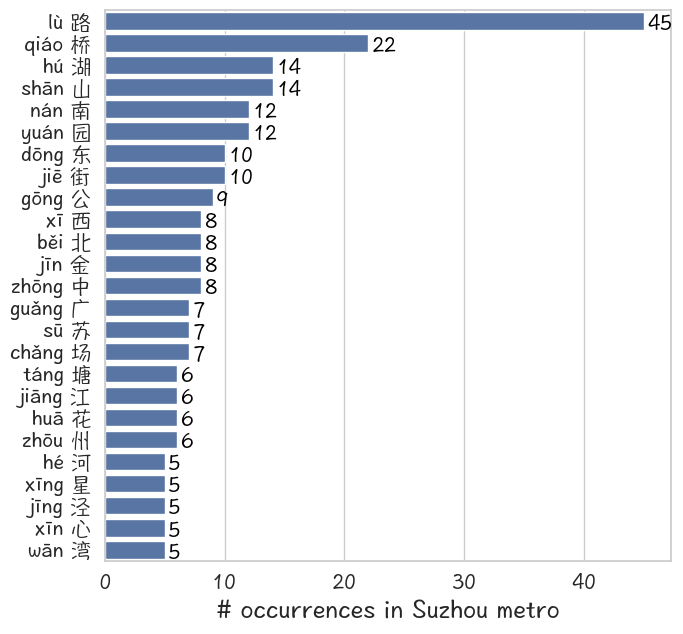

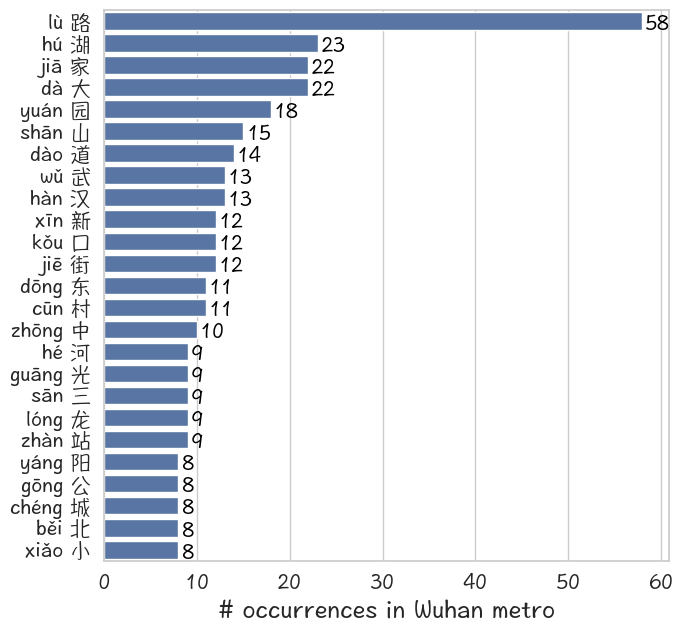

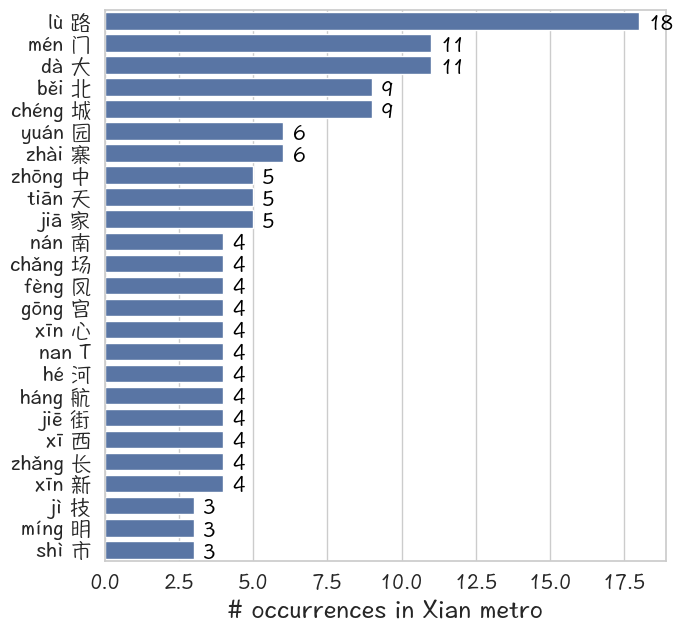

In [195]:
def get_example_stations_onecity(char, df_stations_city, n_examples=3):
    return list(df_stations_city[df_stations_city['chinese'].str.contains(char)].head(n_examples)['chinese'].values)

def compute_onecity_char_ranking(df_stations_city):
    all_char = ''.join(df_stations_city['chinese'].values)
    all_char = list(remove_parentheses_and_numbers(all_char))

    # Get counts of all characters
    df_char_counts = pd.Series(all_char).value_counts().reset_index().rename(columns={"index": 'char'})

    # Add in some required columns with zero counts
    df_char_counts = df_char_counts.merge(df_required_char, on='char', how='outer')
    df_char_counts['count'] = df_char_counts['count'].fillna(0)
    df_char_counts = df_char_counts.sort_values('count', ascending=False).reset_index(drop=True)

    # Enrich dataframe
    df_char_counts['pinyin_all'] = df_char_counts['char'].map(char_to_pinyin_dict)
    df_char_counts['pinyin'] = df_char_counts['pinyin_all'].apply(lambda x: str(x).split(',')[0])
    df_char_counts['char_pinyin'] = df_char_counts.apply(lambda row: f"{row['pinyin']} {row['char']}", axis=1)
    df_char_counts['examples'] = df_char_counts['char'].apply(get_example_stations_onecity, df_stations_city=df_stations_city)
    return df_char_counts

cities = df_stations['city_name'].unique()
dfs_cities = []
for city in cities:
    df_stations_city = df_stations[df_stations['city_name']==city]
    df_city_char_rankings = compute_onecity_char_ranking(df_stations_city)
    df_city_char_rankings['city_name'] = city
    dfs_cities.append(df_city_char_rankings)
    df_plt = df_city_char_rankings.head(25)

    # Plot bars
    # xaxis_limit = 350
    plt.rcParams['font.family'] = 'Hannotate SC'
    plt.figure(figsize=(7,6.5))
    g = sns.barplot(x='count', y='char_pinyin', data=df_plt)

    # Plot numbers
    for index, row in df_plt.iterrows():
        g.text(x=row['count'] + .3,
            y=index + .4,
            s=f"{row['count']:.0f}",
            color='black',
            ha="left",
            size=15)

    plt.ylabel('')
    plt.xlabel(f'# occurrences in {city} metro', size=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    # plt.xlim((0,xaxis_limit))
    plt.tight_layout()
        
    plt.savefig(f'./plots/metro_city_char_ranking_{city}.png')

df_char_rankings_by_city = pd.concat(dfs_cities)
df_char_rankings_by_city.sample(10)


In [196]:
# Compute some normalization
df_n_char_by_city = df_char_rankings_by_city.groupby('city_name')['count'].sum().reset_index().rename(columns={'count': 'city_n_char_total'})
df_n_stations_by_city = df_stations.groupby('city_name')['chinese'].count().reset_index().rename(columns={'chinese': 'city_n_stations_total'})
df_n_char_by_city.head()
df_n_stations_by_city.head()

,city_name,city_n_stations_total
0,Beijing,416
1,Chengdu,329
2,Chongqing,226
3,Dalian,43
4,Guangzhou,293


In [197]:
# Merge in normalization
df_char_rankings_by_city_enr = df_char_rankings_by_city.merge(df_n_char_by_city, on='city_name')
df_char_rankings_by_city_enr = df_char_rankings_by_city_enr.merge(df_n_stations_by_city, on='city_name')
df_char_rankings_by_city_enr['frac_char'] = df_char_rankings_by_city_enr['count'] / df_char_rankings_by_city_enr['city_n_char_total']
df_char_rankings_by_city_enr['frac_station'] = df_char_rankings_by_city_enr['count'] / df_char_rankings_by_city_enr['city_n_stations_total']
df_char_rankings_by_city_enr[df_char_rankings_by_city_enr['char']=='桥'].sort_values('frac_station', ascending=False)

,char,count,pinyin_all,pinyin,char_pinyin,examples,city_name,city_n_char_total,city_n_stations_total,frac_char,frac_station
2961,桥,22.0,qiáo,qiáo,qiáo 桥,"[乐桥, 新家桥, 宝带桥南]",Suzhou,560.0,174,0.039286,0.126437
0,桥,42.0,qiáo,qiáo,qiáo 桥,"[双桥, 八里桥, 土桥]",Beijing,1327.0,416,0.031650,0.100962
1407,桥,19.0,qiáo,qiáo,qiáo 桥,"[龙翔桥, 曹家桥, 沈塘桥]",Hangzhou,785.0,257,0.024204,0.073930
402,桥,23.0,qiáo,qiáo,qiáo 桥,"[倪家桥, 东门大桥, 驷马桥]",Chengdu,1057.0,329,0.021760,0.069909
2863,桥,4.0,qiáo,qiáo,qiáo 桥,"[长城桥, 朝晖桥, 建和桥]",Shijiazhuang,186.0,62,0.021505,0.064516
1726,桥,15.0,qiáo,qiáo,qiáo 桥,"[八百桥, 八卦洲大桥南, 长江大桥北]",Nanjing,844.0,247,0.017773,0.060729
748,桥,13.0,qiáo,qiáo,qiáo 桥,"[上桥, 天星桥, 南桥寺]",Chongqing,681.0,226,0.019090,0.057522
2056,桥,22.0,qiáo,qiáo,qiáo 桥,"[虹桥火车站, 虹桥2号航站楼, 虹桥路]",Shanghai,1386.0,408,0.015873,0.053922
1095,桥,1.0,qiáo,qiáo,qiáo 桥,[青泥洼桥],Dalian,133.0,43,0.007519,0.023256
3551,桥,2.0,qiáo,qiáo,qiáo 桥,"[三桥, 洒金桥]",Xian,348.0,102,0.005747,0.019608


In [198]:
# Most popular characters, variance by city
N_CHAR = 20
top_char = char_counts.head(N_CHAR+1)['char'].values[1:]
print(top_char)

N_CITIES = 10
top_cities = df_n_stations_by_city.sort_values('city_n_stations_total', ascending=False).head(N_CITIES)['city_name'].values
print(top_cities)

df_plt = df_char_rankings_by_city_enr[
    (df_char_rankings_by_city_enr['char'].isin(top_char)) & (df_char_rankings_by_city_enr['city_name'].isin(top_cities))
    ]
df_plt['percent_station'] = df_plt['frac_station'] * 100
df_plt = df_plt.merge(char_counts[['char', 'count']].rename(columns={'count': 'count_all_cities'}), on='char')
df_plt.sample(5)

['大' '园' '桥' '东' '南' '北' '西' '山' '新' '中' '街' '城' '家' '湖' '场' '公' '龙' '门'
 '村' '江']
['Beijing' 'Shanghai' 'Shenzhen' 'Chengdu' 'Guangzhou' 'Wuhan' 'Hangzhou'
 'Nanjing' 'Chongqing' 'Suzhou']


/var/folders/z8/s7_mn6894xd5kj7pdpx6t6100000gn/T/ipykernel_58559/2512475744.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plt['percent_station'] = df_plt['frac_station'] * 100


,char,count,pinyin_all,pinyin,char_pinyin,examples,city_name,city_n_char_total,city_n_stations_total,frac_char,frac_station,percent_station,count_all_cities
48,中,8.0,"zhōng,zhòng",zhōng,zhōng 中,"[奥体中心, 园博中心, 中梁山]",Chongqing,681.0,226,0.011747,0.035398,3.539823,122
37,门,4.0,mén,mén,mén 门,"[通惠门, 东门大桥, 新南门]",Chengdu,1057.0,329,0.003784,0.012158,1.215805,90
40,家,26.0,"jiā,jia,jià,jie,gū",jiā,jiā 家,"[冉家坝, 罗家坝, 谢家湾]",Chongqing,681.0,226,0.038179,0.115044,11.504425,106
119,公,4.0,gōng,gōng,gōng 公,"[凤凰山公园, 临江·青奥体育公园, 羊山公园]",Nanjing,844.0,247,0.004739,0.016194,1.619433,102
78,家,1.0,"jiā,jia,jià,jie,gū",jiā,jiā 家,[陈家祠],Guangzhou,787.0,293,0.001271,0.003413,0.341297,106


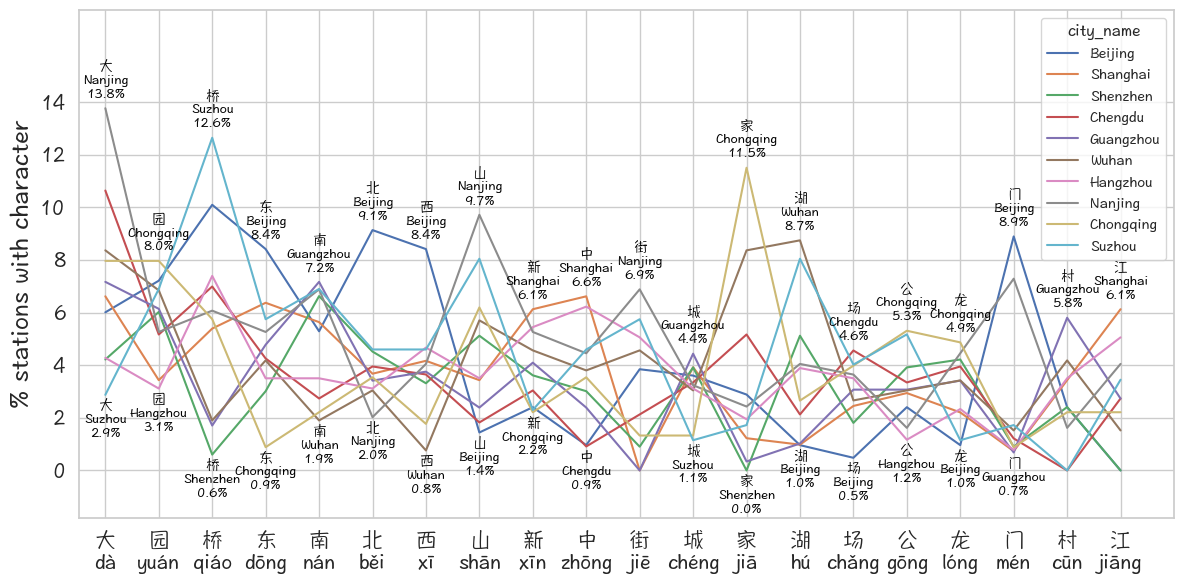

In [204]:
# y = city; x = fraction of stations; color = character
df_plt = df_plt.sort_values(['city_n_stations_total', 'count_all_cities'], ascending=False)
df_plt['char_pinyin2'] = df_plt.apply(lambda row: f"{row['char']}\n{row['pinyin']}", axis=1)
df_plt['city_rank_for_char'] = df_plt.groupby('char')['frac_station'] \
                                  .rank(ascending=False, method='dense') \
                                  .astype(int)

plt.rcParams['font.family'] = 'Hannotate SC'
plt.figure(figsize=(12, 6))
g = sns.lineplot(data=df_plt, y="percent_station", x="char_pinyin2", hue="city_name")
plt.xlabel('')
plt.ylabel(f'% stations with character', size=18)
plt.xticks(fontsize=15)
plt.yticks(np.arange(0,16,2), fontsize=15)
plt.ylim((-1.8,17.5))
plt.xlim((-.5,N_CHAR))

# Add text for most extreme points
for index, row in df_plt.iterrows():
    if row['city_rank_for_char'] == 1:
        g.text(x=row['char_pinyin2'],
            y=row['percent_station']+.4,
            s=f"{row['char']}\n{row['city_name']}\n{row['percent_station']:.1f}%",
            color='black',
            ha="center",
            size=10)

    if row['city_rank_for_char'] == 10:
        g.text(x=row['char_pinyin2'],
            y=row['percent_station']-1.6,
            s=f"{row['char']}\n{row['city_name']}\n{row['percent_station']:.1f}%",
            color='black',
            ha="center",
            size=10)


# Save
plt.tight_layout()
plt.savefig(f'./plots/metro_char_comparison_by_city.png')

In [ ]:

df_plt.sort_values(['count_all_cities', 'city_rank_for_char'], ascending=False).head(20)

,char,count,pinyin_all,pinyin,char_pinyin,examples,city_name,city_n_char_total,city_n_stations_total,frac_char,frac_station,percent_station,count_all_cities,char_pinyin2,city_rank_for_char
167,大,5,"dà,dài,tài",dà,dà 大,"[大湾, 葑亭大道, 松陵大道]",Suzhou,560,174,0.008929,0.028736,2.873563,244,大\ndà,10
141,大,14,"dà,dài,tài",dà,dà 大,"[大剧院, 深大, 大新]",Shenzhen,871,332,0.016073,0.042169,4.216867,244,大\ndà,9
83,大,11,"dà,dài,tài",dà,dà 大,"[杭州大会展中心, 港城大道, 大关]",Hangzhou,785,257,0.014013,0.042802,4.280156,244,大\ndà,8
6,大,25,"dà,dài,tài",dà,dà 大,"[大望路, 传媒大学, 鼓楼大街]",Beijing,1327,416,0.018839,0.060096,6.009615,244,大\ndà,7
118,大,27,"dà,dài,tài",dà,dà 大,"[一大会址·黄陂南路, 世纪大道, 远东大道]",Shanghai,1386,408,0.019481,0.066176,6.617647,244,大\ndà,6
58,大,21,"dà,dài,tài",dà,dà 大,"[白云大道北, 大塘, 大石]",Guangzhou,787,293,0.026684,0.071672,7.167235,244,大\ndà,5
40,大,18,"dà,dài,tài",dà,dà 大,"[重庆大学[2], 民安大道, 大坪]",Chongqing,681,226,0.026432,0.079646,7.964602,244,大\ndà,4
175,大,22,"dà,dài,tài",dà,dà 大,"[东吴大道, 五环大道, 大智路]",Wuhan,884,263,0.024887,0.083650,8.365019,244,大\ndà,3
19,大,35,"dà,dài,tài",dà,dà 大,"[华府大道, 迎宾大道, 中医大省医院]",Chengdu,1057,329,0.033113,0.106383,10.638298,244,大\ndà,2
97,大,34,"dà,dài,tài",dà,dà 大,"[八卦洲大桥南, 长江大桥北, 诚信大道]",Nanjing,844,247,0.040284,0.137652,13.765182,244,大\ndà,1
